<a href="https://colab.research.google.com/github/ixnp/DS510_TeamProject_FraudDetectionAI/blob/main/CreditCardFraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# %% [markdown]
# # Credit Card Fraud Detection
#
# This script is formatted as a Jupyter-friendly Python script (use with JupyterLab/Notebook or run as a .py with an editor that understands `# %%` cells).
#
# **Dataset**: `creditcard.csv` (Kaggle: mlg-ulb/creditcardfraud)
# Place `creditcard.csv` in the same folder as this notebook or update the path in the data loading cell.
#
# Sections:
# 1. Setup & installs
# 2. Load data & quick checks
# 3. Exploratory Data Analysis (EDA)
# 4. Preprocessing & feature engineering
# 5. Train/Test split + balancing (SMOTE example)
# 6. Modeling (LogisticRegression, RandomForest, XGBoost)
# 7. Evaluation & metrics
# 8. Save model


## 1) Setup - installs

In [15]:

!pip install -q imbalanced-learn xgboost
!pip install kagglehub[pandas-datasets]


## 2) Imports

In [16]:

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, roc_curve, auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Try/except for XGBoost since it may not be installed by default
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception:
    xgb_available = False

# For handling imbalance
from imblearn.over_sampling import SMOTE


## 3) Load data & quick checks
### Ensure `creditcard.csv` is present in the same directory. If you downloaded from Kaggle, the filename should match.


In [25]:
# Adjust path if needed
# DATA_PATH = '/kaggle/input/creditcardfraud/creditcard.csv'
# data = pd.read_csv(DATA_PATH)

import kagglehub
import os

# Download the dataset from KaggleHub
dataset_url = "mlg-ulb/creditcardfraud"
dataset_path = kagglehub.dataset_download(dataset_url)

# List files in the downloaded directory to verify the path and filename
print("Files in downloaded dataset directory:")
for root, dirs, files in os.walk(dataset_path):
    for name in files:
        print(os.path.join(root, name))

# Construct the full path to the CSV file within the downloaded dataset
# Assuming the file is directly in the downloaded path based on typical dataset structures
file_path = os.path.join(dataset_path, 'creditcard.csv')

# Load the dataset from the downloaded path
data = pd.read_csv(file_path)


print('Shape:', data.shape)
print('\nColumns:', data.columns.tolist())

# Quick peek
display(data.head())

# Basic info
print('\nInfo:')
print(data.info())

print('\nMissing values per column:')
print(data.isnull().sum().sort_values(ascending=False).head())

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Files in downloaded dataset directory:
/kaggle/input/creditcardfraud/creditcard.csv
Shape: (284807, 31)

Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21

### Target distribution (class imbalance)


Class
0    284315
1       492
Name: count, dtype: int64

Proportions:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


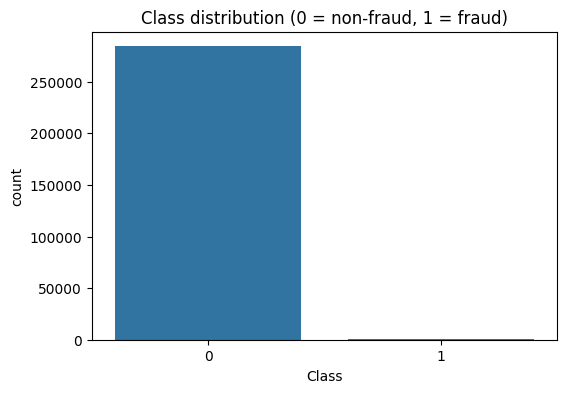

In [26]:
print(data['Class'].value_counts())
print('\nProportions:')
print(data['Class'].value_counts(normalize=True))

plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=data)
plt.title('Class distribution (0 = non-fraud, 1 = fraud)')
plt.show()


## 4) Exploratory Data Analysis (EDA)
### We'll inspect `Amount`, `Time`, and a few PCA components `V1`..`V28` for differences between fraud and non-fraud.


In [ ]:
# Amount distribution
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(data['Amount'], bins=50, kde=False)
plt.title('Transaction Amount (raw)')

plt.subplot(1,2,2)
sns.boxplot(x='Class', y='Amount', data=data)
plt.title('Amount by Class')
plt.show()

# Log-transformed Amount (optional, helps models)
data['Amount_log'] = np.log1p(data['Amount'])
plt.figure(figsize=(8,4))
sns.boxplot(x='Class', y='Amount_log', data=data)
plt.title('Log(Amount+1) by Class')
plt.show()


In [ ]:
# Time: convert seconds to hours-of-day roughly (if you want to look for time-of-day patterns).
# Note: 'Time' is seconds elapsed between each transaction and the first transaction in the dataset.
# We will look at simple distribution splits.

data['Hour'] = (data['Time'] // 3600) % 24
plt.figure(figsize=(12,4))
sns.histplot(data[data['Class']==0]['Hour'], label='Non-fraud', stat='count', bins=24, alpha=0.6)
sns.histplot(data[data['Class']==1]['Hour'], label='Fraud', stat='count', bins=24, alpha=0.6)
plt.legend()
plt.title('Transaction Counts by Hour (approx)')
plt.show()


In [ ]:
# Compare a few PCA components distributions between classes
pca_cols = [c for c in data.columns if c.startswith('V')][:6]  # show first 6 for brevity
plt.figure(figsize=(14,8))
for i, col in enumerate(pca_cols, 1):
    plt.subplot(3,2,i)
    sns.kdeplot(data.loc[data['Class']==0, col], label='Non-fraud', common_norm=False)
    sns.kdeplot(data.loc[data['Class']==1, col], label='Fraud', common_norm=False)
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Correlation matrix — we will look at correlation with Class only to keep it readable
corr_with_class = data.corr()['Class'].sort_values(ascending=False)
print('Top correlations with Class:')
print(corr_with_class.head(10))
print('\nLowest correlations with Class:')
print(corr_with_class.tail(10))


## 5) Preprocessing & feature engineering
- Drop columns we don't need (raw `Amount` maybe kept but we will prefer `Amount_log`)
- Scale features (StandardScaler) where appropriate


In [ ]:
FEATURES = [c for c in data.columns if c not in ['Class', 'Time']]  # keep Time-derived features if needed
TARGET = 'Class'

# We'll drop 'Amount' and 'Time' from direct modeling but keep Amount_log and Hour (optional)
if 'Amount' in FEATURES:
    FEATURES.remove('Amount')
if 'Time' in FEATURES:
    pass

X = data[FEATURES]
y = data[TARGET]

# Standardize 'Amount_log' and optionally 'Hour' (hours are cyclic but this is a simple approach)
scaler = StandardScaler()
X[['Amount_log', 'Hour']] = scaler.fit_transform(X[['Amount_log', 'Hour']])

print('Feature matrix shape:', X.shape)


## 6) Train/Test split and handling class imbalance
- We'll use a stratified split to preserve class ratios. Then apply SMOTE on training set to balance classes for some models.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Train class distribution:')
print(y_train.value_counts(normalize=True))
print('\nTest class distribution:')
print(y_test.value_counts(normalize=True))

# Apply SMOTE on training data
smote = SMOTE(random_state=42, sampling_strategy='auto')  # will oversample minority to match majority
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print('\nAfter SMOTE - train distribution:')
print(pd.Series(y_train_res).value_counts())


## 7) Modeling — baseline models
### We'll train Logistic Regression, Random Forest, and XGBoost.

In [ ]:
models = {}

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)
models['LogisticRegression'] = lr

# Random Forest
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train_res, y_train_res)
models['RandomForest'] = rf

# XGBoost (optional)
if xgb_available:
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb.fit(X_train_res, y_train_res)
    models['XGBoost'] = xgb
else:
    print('XGBoost not available — skip.')


## 8) Evaluation helpers


In [ ]:
def eval_model(model, X_test, y_test, name=None):
    if name is None:
        name = model.__class__.__name__
    y_pred = model.predict(X_test)
    y_proba = None
    try:
        y_proba = model.predict_proba(X_test)[:,1]
    except Exception:
        try:
            y_proba = model.decision_function(X_test)
        except Exception:
            pass

    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred, digits=4))
    if y_proba is not None:
        roc = roc_auc_score(y_test, y_proba)
        print('ROC AUC:', round(roc,4))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix:\n', cm)
    print('\n')

In [ ]:
# Evaluate all models
for name, mdl in models.items():
    eval_model(mdl, X_test, y_test, name=name)

# Precision-Recall curve for the best model

In [ ]:
best_model_name = 'RandomForest' if 'RandomForest' in models else list(models.keys())[0]
best_model = models[best_model_name]

try:
    y_scores = best_model.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({best_model_name})')
    plt.legend()
    plt.show()
except Exception as e:
    print('Could not plot PR curve:', e)


## 9) Feature importance (for tree-based models)


In [ ]:
if 'RandomForest' in models:
    importances = models['RandomForest'].feature_importances_
    fi = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    display(fi.head(20))
    plt.figure(figsize=(8,6))
    sns.barplot(x=fi.head(20), y=fi.head(20).index)
    plt.title('Top 20 Feature Importances (RandomForest)')
    plt.show()


## 10) Save the best model to disk


In [ ]:
import joblib
MODEL_PATH = 'best_model.joblib'
joblib.dump(best_model, MODEL_PATH)
print('Saved best model to', MODEL_PATH)


## Notes, next steps & improvements
- Try hyperparameter tuning (GridSearchCV or RandomizedSearchCV) with `roc_auc` as scoring.
- Try other balancing strategies (ADASYN, undersampling, ensemble approaches).
- Use time-based validation if transactions are time-ordered (i.e., avoid leakage by splitting by time).
- Feature engineering ideas: rolling statistics per card-holder (if card-holder id exists), time-deltas, frequency of transactions.
- Consider cost-sensitive learning (penalize false negatives higher than false positives).

